# Single Response Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import fsolve

In [2]:
# experimental data - measurements
tspan = np.array([0, 0.1, 0.2, 0.4, 0.8, 1])
Ca_data = np.array([2.0081,  1.5512,  1.1903,  0.7160,  0.2562,  0.1495])
Ca0 = Ca_data[0]

# 1st example with curve_fit

The estimated value of rate constant is 2.588943185962723


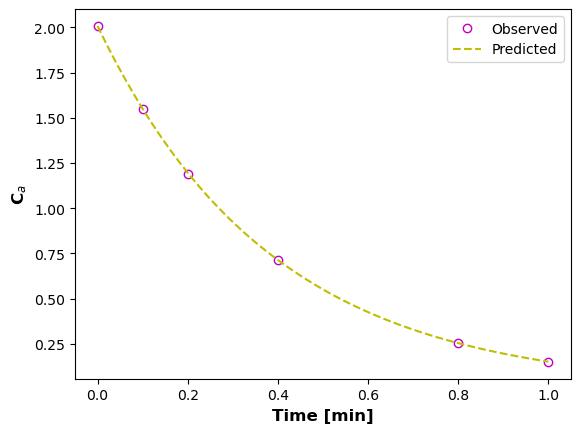

In [17]:
def y_calc(t, p):

    sol_ode = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        t_eval = t,
                        args = (p, ))

    return sol_ode.y[0]

# print(y_calc(tspan, 1))

# curve_fit(y_calc, t = tspan, y = Ca_data, p = p0)
params, kcov = curve_fit(y_calc, tspan, Ca_data, p0 = 1.3)

# unpack params
k = params

# find a sequence of inputs between the smallest and largest known inputs
tfit = np.linspace(min(tspan), max(tspan))

# calculate the output for the range
fit_y = y_calc(tfit, k)

fig = plt.subplots(dpi = 100)
plt.plot(tspan, Ca_data, 'mo', mfc = 'None', label='Observed')
plt.plot(tfit, fit_y, 'y--', label='Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with SLSQP

The estimated value of rate constant is 2.5889379670306103


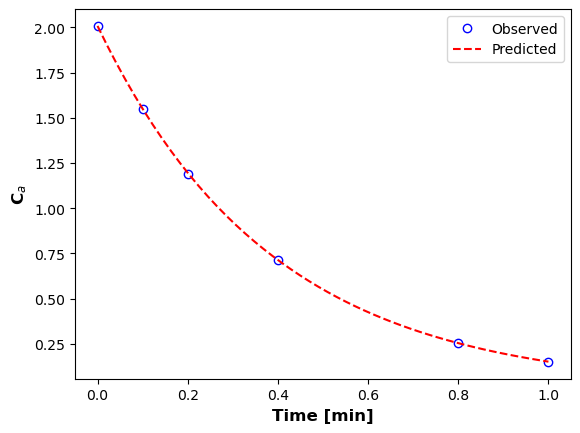

In [4]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        args=(p,), 
                        t_eval = t)
    
    return ode_sol.y[0]

# where p is the vector of the unknown parameters, t is the independent variable, and y represents the measurements
min_fun = lambda p, t, y: np.linalg.norm(y - y_calc(t, p))

# args = (experimental values)
res_min = minimize(min_fun, 
               [1.3], # initial value of k
               args=(tspan, Ca_data), 
               method='SLSQP',
               bounds=[(0.0, np.inf)])

k = res_min.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "bo", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "r--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with least_squares

The estimated value of rate constant is 2.5889432091928746


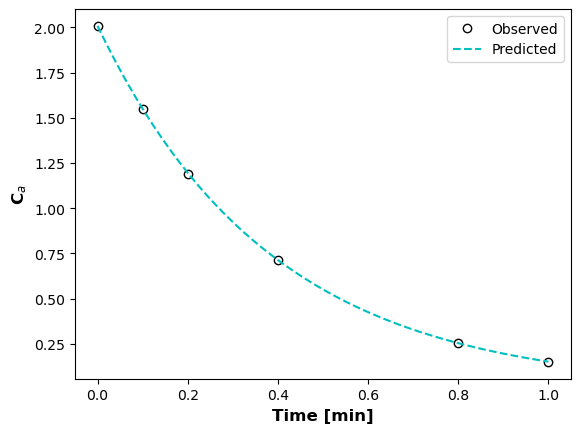

In [5]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), [Ca0], 
                        t_eval = t,
                        args = (p,))
    
    return ode_sol.y[0]


min_fun = lambda p, t, y: np.linalg.norm(y - y_calc(t, p))

# least_squares(min_fun, p = p0, bnds, args = (t = tspan, y = Ca_data)) - arguments of lambda follow the same order p, t, y
res_lsq = least_squares(min_fun, 
                        [2.5], 
                        bounds = (0.0, np.inf), 
                        args = (tspan, Ca_data))

k = res_lsq.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "ko", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "c--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 2nd example with curve_fit (fake data)

b=0.0198388668733205, y0 = 0.9822641635782716


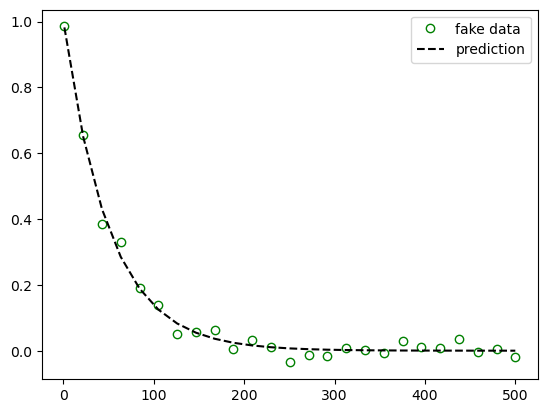

In [6]:
# when we have more than 1 parameter to optimize use *
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # we only care about the argument of the ode
    
    return sol.y[0]

xmin, xmax = 1, 500
n_points = 25 # here we can see that a significant lower number of points are needed in comparison to least_squares method

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

popt, pcov = curve_fit(curve, xdata, ydata, p0=p0)
b, y0 = popt

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'go', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'k--', label = 'prediction')
plt.legend()

# 2nd example with least_squares (fake data)

b=0.019830739154713395, y0 = 0.980193532981472


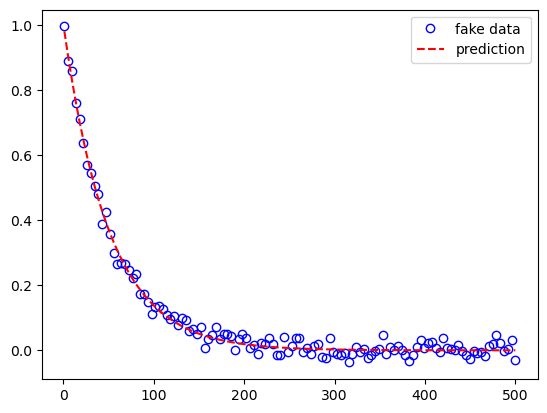

In [25]:
# when we have more than 1 parameter to optimize use * for unpacking
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # argument existed in ode
    
    return sol.y[0]

xmin, xmax = 1, 500
n_points = 120 # note that more points are needed in order to fit the curve in comparison to curve_fit

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

res_lsq = least_squares(lambda p, t, y: np.linalg.norm(y - curve(t, *p)), 
                        p0,
                        bounds = ([0, 0], np.inf),
                        args = (xdata, ydata))

b, y0 = res_lsq.x

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'bo', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'r--', label = 'prediction')
plt.legend()

# 3rd example - enzymatic reaction

Here we consider an enzymatic reaction. There are 11 residuals defined as

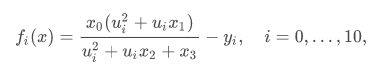

where $y_i$ are measurement values and $u_i$ are values of the independent variable. The unknown vector of parameters is $x = (x_0, x_1, x_2, x_3)^T$. It is recommended to compute Jacobian matrix in a closed form:

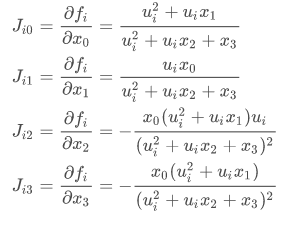

To find a physically meaningful solution, avoid potential division by zero and assure convergence to the global minimum we impose constraints

$0 \leq x_j \leq100,~j=0,1,2,3$

In [10]:
def model(x, u):
    
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])

def fun(x, u, y):
    
    return model(x, u) - y

# returns the derivatives of the model based on the unknown parameters for each Ji
def jac(x, u, y):
    
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    
    return J

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


In [26]:
# independent variable
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])

# measurements
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])

# initial values
x0 = np.array([2.5, 3.9, 4.15, 3.9])

res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)
res

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


 active_mask: array([0, 0, 0, 0])
        cost: 0.0001537528023415085
         fun: array([-1.30664586e-03, -1.87579954e-03,  8.91958340e-03, -1.11095297e-02,
        8.35200541e-03, -1.73677561e-04,  2.58387522e-05,  1.26262347e-03,
       -3.52355168e-03,  6.16759030e-04, -3.88872553e-03])
        grad: array([-4.52564650e-10, -1.44529678e-10,  1.55211428e-09,  8.54196275e-08])
         jac: array([[ 1.00823291,  0.04638017, -0.04676201, -0.0116905 ],
       [ 1.0000944 ,  0.08799521, -0.08800352, -0.04400176],
       [ 0.94613022,  0.15312606, -0.14487719, -0.14487719],
       [ 0.77222944,  0.21537647, -0.16632005, -0.33264011],
       [ 0.4810639 ,  0.21017745, -0.10110878, -0.40443513],
       [ 0.32429656,  0.17450668, -0.05659192, -0.33887375],
       [ 0.23664118,  0.14424711, -0.03413481, -0.27307844],
       [ 0.18392905,  0.12173779, -0.02239112, -0.22391116],
       [ 0.14925079,  0.10479279, -0.01564041, -0.18775999],
       [ 0.12508303,  0.09180226, -0.01148291, -0.1608

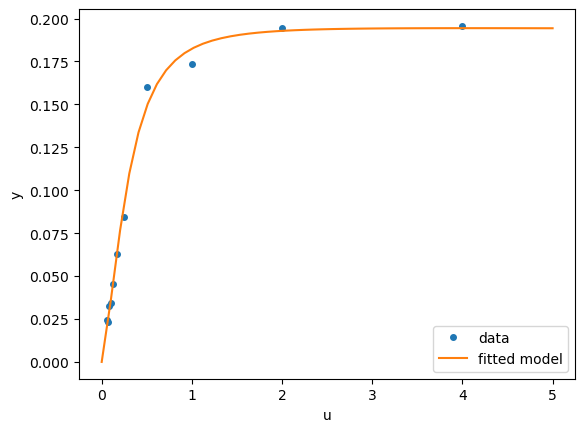

In [12]:
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()